In [263]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [49]:
test=pd.read_csv('titanic/test.csv')
train=pd.read_csv('titanic/train.csv')

In [45]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [133]:
print(max(train['Fare']))
print(min(train['Age']))
print(train['Embarked'].unique())
print(train['Sex'].unique())
print(len(train['Cabin'].unique()))

512.3292
0.42
['S' 'C' 'Q' nan]
['male' 'female']
148


In [160]:
test_data=pd.get_dummies(test, columns=['Sex','Cabin','Embarked'], dtype=int)
test_data=test_data.drop(['Name', 'Ticket'],axis=1)
test_data=test_data.dropna()
print(test_data.shape)
testloader=DataLoader(test_data,batch_size=100)
test_data.head()

(331, 87)


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A11,Cabin_A18,...,Cabin_F E46,Cabin_F E57,Cabin_F G63,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,893,3,47.0,1,0,7.0000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [224]:
train_data=pd.get_dummies(train, columns=['Sex','Cabin','Embarked'], dtype=int)
train_data=train_data.drop(['Name', 'Ticket'],axis=1)
train_data=train_data.dropna()
print(train_data.shape)
xval=torch.tensor(train_data.drop('Survived',axis=1).values, dtype=torch.float32)
targets=pd.get_dummies(train_data['Survived'].values,dtype=int)
yval=torch.tensor(targets.values, dtype=torch.float32)
split=TensorDataset(xval,yval)
train_size = int(0.8 * len(split))
test_size = len(split) - train_size

# Random split
train_dataset, test_dataset = random_split(split, [train_size, test_size])
trainloader=DataLoader(train_dataset,batch_size=50)
train_data.head()

(714, 159)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [227]:
model=nn.Sequential(
    nn.Linear(158,2*158),
    nn.ReLU(),
    nn.Linear(2*158,2*158),
    nn.ReLU(),
    nn.Linear(2*158,2),
    nn.Sigmoid()
)

criterion=nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
    

In [260]:
epochs=20
epoch=0
epochtrack=[]
lossvals=[]
for x,y in trainloader:
    model.train()
    output=model(x)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")
    epochtrack.append(epoch)
    lossvals.append(loss.item())
    epoch+=1

Epoch [1/20], Loss: 0.22088806331157684
Epoch [2/20], Loss: 0.22345800697803497
Epoch [3/20], Loss: 0.270018607378006
Epoch [4/20], Loss: 0.35876786708831787
Epoch [5/20], Loss: 0.2019609659910202
Epoch [6/20], Loss: 0.27055349946022034
Epoch [7/20], Loss: 0.293567419052124
Epoch [8/20], Loss: 0.22146837413311005
Epoch [9/20], Loss: 0.24182824790477753
Epoch [10/20], Loss: 0.22381605207920074
Epoch [11/20], Loss: 0.25380146503448486
Epoch [12/20], Loss: 0.25439292192459106


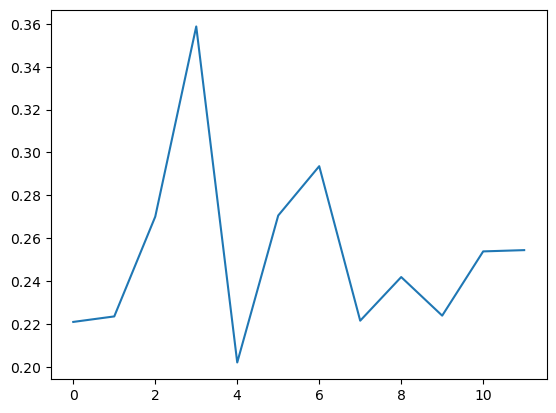

In [261]:
plt.plot(epochtrack,lossvals)

In [201]:
xtrainset, xtestset, ytrainset, ytestset = train_test_split(xval,yval, test_size=0.2)

In [202]:
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(xtrainset,ytrainset)

RandomForestClassifier(random_state=42)

In [276]:
predictions=model1.predict(test_dataset.dataset.tensors[0].detach().numpy())
predictions=np.asarray([rounds(x) for x in predictions])
print(accuracy_score(test_dataset.dataset.tensors[1].detach().numpy(), predictions))

0.9649859943977591


In [262]:
model.eval()
rounds = lambda t: [0,1] if t[0]<=t[1] else [1,0]
with torch.no_grad():
    outputs=model(test_dataset.dataset.tensors[0].detach())
    predicts=np.asarray([rounds(x) for x in outputs])
print('Accuracy Score: ',accuracy_score(test_dataset.dataset.tensors[1].detach().numpy(),predicts))
    

Accuracy Score:  0.6764705882352942


In [220]:
train.groupby('Sex')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


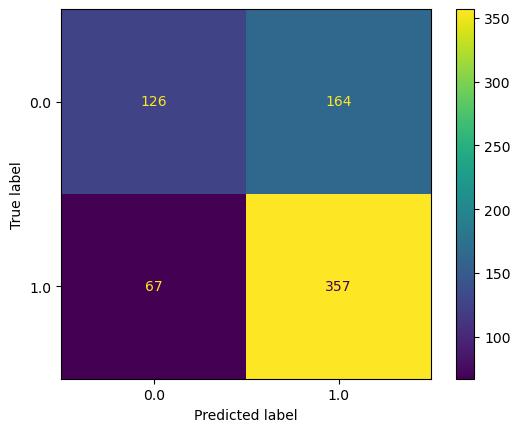

In [267]:
ConfusionMatrixDisplay.from_predictions(test_dataset.dataset.tensors[1].detach().numpy()[:,0],predicts[:,0])

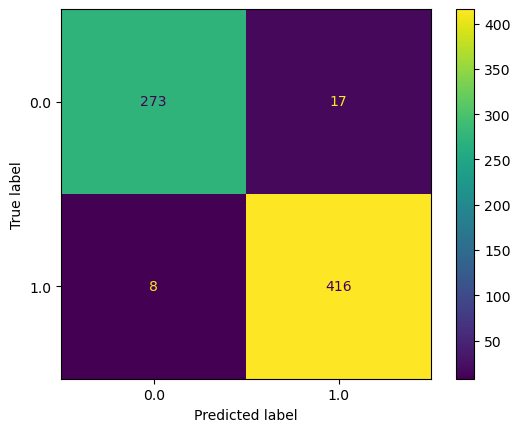

In [279]:
ConfusionMatrixDisplay.from_predictions(test_dataset.dataset.tensors[1].detach().numpy()[:,0],predictions[:,0])